# Trabajo Practico - Desarrollo de software para el cálculo de parámetros acústicos ISO 3382 (3er entrega)

## Fecha de entrega

*Ingresar fecha*

## Integrantes

* <Nombre, Apellido>
* <Nombre, Apellido>
* <Nombre, Apellido>

## Entrega FINAL ¡LEER ATENTAMENTE!

En esta entrega se completa todo el notebook como se realizó anteriormente, pero con la diferencia que **NO SE ENTREGA ESTE NOTEBOOK**, en contrapartida deben entregar las funciones en uno o varios archivos `.py`, para ser ejecutados y evaluados con nota. 

Es importante entregar todos los elementos necesarios para reproducir *end-to-end* el software. Para eso se deben integrar todas las funciones de las anteriores entregas en uno o varios archivos `.py` sin olvidar ningún detalle.

Se recomienda seguir una estructura del tipo [`if __name__ == "__main__"`](https://www.freecodecamp.org/espanol/news/python-if-name-main/) para la estructura del archivo. Recuerden agregar los test implementados. Al final de este notebook hay un diagrama de flujo ilustrativo de como combinar las funciones (no es la única manera).

> **Nota:** Como figura a continuación, comparar los resultados obtenidos con la señal sintetizada, con las señales descargadas y realizar una tabla comparativa. Ademas se puede hacer uso de herramientas como REW(Room Acoustics Software) para comparar los resultados obtenidos. **La diferencia debe ser menor a 0.5 s en las frecuencias centrales de 500 Hz a 2000 Hz**.

### Aspectos generales del notebook

Esta entrega es la final, en el mismo se debe volcar toda la informacion relevante del proyecto. Recordamos las pautas más importantes:

* Todas las funciones deben contar con su [docstring](https://realpython.com/documenting-python-code/#docstring-types), como figura en la función de ejemplo (`ruidoRosa_voss`)(1er entrega).
* Todos los gráficos deben tener correctamente etiquetados los ejes.
* Enviar los archivos `.py`, el informe en formato `.pdf` y todos los archivos para reproducir los resultados por Slack.
* Todas las señales de audio deben ser grabadas en formato .wav en la misma función que las genera.

## Librerias utilizadas
Agregar todas las librerias utilizadas, algunas a modo de ejemplo:

In [64]:
import numpy as np
from matplotlib import pyplot as plt
import sounddevice as sd
import pandas as pd
from scipy.io import wavfile
from scipy import signal
from scipy.integrate import quad
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import fftconvolve

import sys
sys.path.append('../')
from util.functions import plot, askBooleanInput, plotWAV, getWAVData, plotDataFrame, createFigure, getDataFrameData, generarSineSweepYFiltroInverso, getImpulseResponse

fs = 44100

## Función suavizado de señal

Investigar e implementar en una única función alguna o todas las técnicas que se mencionan a continuación:

### 1. Transformada de Hilbert

Se trata de un operador lineal definido por la convolución de la señal que deseamos transformar $s(t)$ y la función $1/\pi t$:
\begin{equation}
H\big\{s(t)\big\} = s(t) * \frac{1}{\pi t} 
\tag{12}
\end{equation}
Si la calculamos en el dominio de la frecuencia, 

\begin{equation}
H\big\{S(w)\big\} =  -j\cdot sgn(w)\cdot S(w)
\tag{13}
\end{equation}

donde la funcion $sgn(w)$ representa el signo de la frecuencia:

\begin{equation}
sgn (w) = 
\left\{
\begin{array}{ll}
      -1 & w<1 \\
      0 & w=0 \\
      1 & w>1 \\
\end{array} 
\right .
\tag{14}
\end{equation}

Se utiliza con la función original para obtener la llamada señal analitica de $s(t)$ llamada $s_{a}(t)$, expresada como:

\begin{equation}
s_{a}(t) = s(t) + j \cdot H\big\{s(t)\big\}
\tag{15}
\end{equation}

La transformada de Hilbert produce entonces el efecto de desplazar la componente de frecuencias negativas de  $s(t)$ +90° y las partes de frecuencias positivas −90. La señal analitica $s_{a}(t)$ correspondiente a una señal real $s(t)$ se define como una señal compleja cuyo espectro de frecuencias es nulo para frecuencias negativas, y cuya parte real es igual a la señal original $s(t)$. Tambien podemos afirmar que una señal es analitica si su parte imaginaria es igual a la Transformada de Hilbert de su parte real. 
De la  señal analitica se puede obtener fácilmente la envolvente de la señal, conservando tan solo el modulo de dicha transformación. Otra interpretación es que la transformada de Hilbert de $s(t)$ es la salida de un sistema LTI con entrada $s(t)$ y respuesta al impulso $1/\pi t$.

**Consigna:** Realizar una función que aplique la transformada de Hilbert a una señal de entrada.

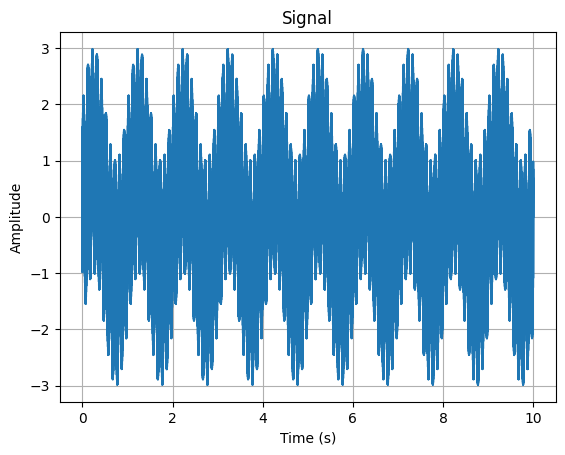

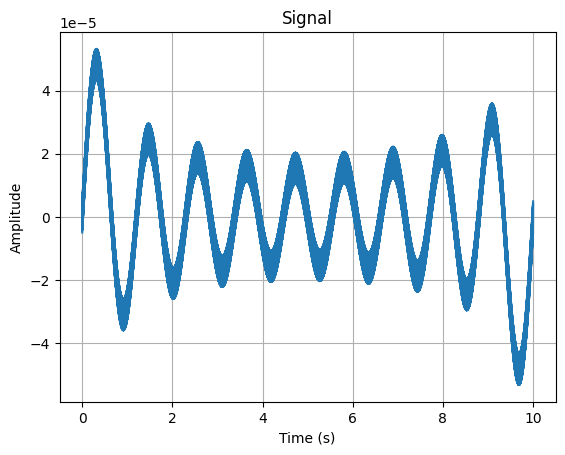

In [66]:
def hilbertTransform(signal):
    signalSpectrum = fft(signal)
    frequencies = fftfreq(len(signal), 1/fs)

    for i, frequency in enumerate(frequencies):
        if frequency < 1:
            frequencies[i] = -1
        else:
            frequencies[i] = 1
    frequencies[0] = 0

    hilbertTransformSignalSpectrum = -1j * frequencies * signalSpectrum
    hilbertTransformSignal = ifft(hilbertTransformSignalSpectrum)

    return np.imag(hilbertTransformSignal)


t = np.linspace(0, 10, fs*10)
signal = np.sin(2*np.pi*t) + np.sin(10 * 2*np.pi*t) + np.sin(16000 * 2*np.pi*t)

hilbertTransformSignal = hilbertTransform(signal)

plot(t, signal)
plot(t, hilbertTransformSignal)



### 2. Filtro de promedio móvil

Se trata de una técnica de filtrado, la cual devuelve un valor de salida igual al promedio de $L$ muestras, dando una lista de números los cuales cada uno es el promedio de un subconjunto de los datos originales. Para cada muestra de nuestra señal, obtenemos la nueva funcion filtrada aplicando la siguiente formula:

\begin{equation}
y[i]=\frac{1}{L}\sum_{j=0}^{L-1}x[i-j]
\tag{16}
\end{equation}

donde $i$ es la muestra actual que se esta evaluando,$x[i]$ la señal original y $y[i]$ la señal filtrada.
El filtro permite filtrar las altas frecuencias (pasa bajo), devolviendo una versión suavizada de la señal.

**Consigna:** Realizar una función que aplique el filtro de promedio móvil a una señal de entrada.

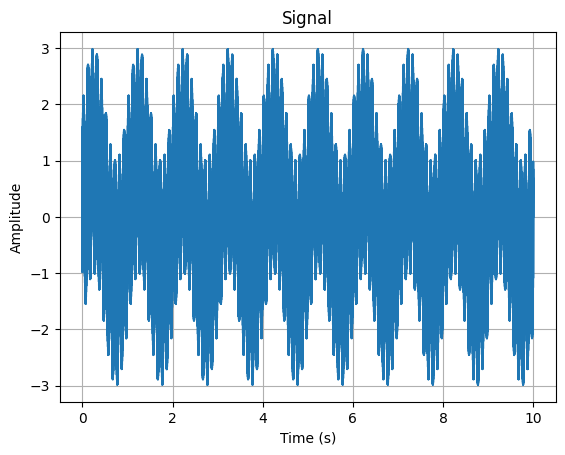

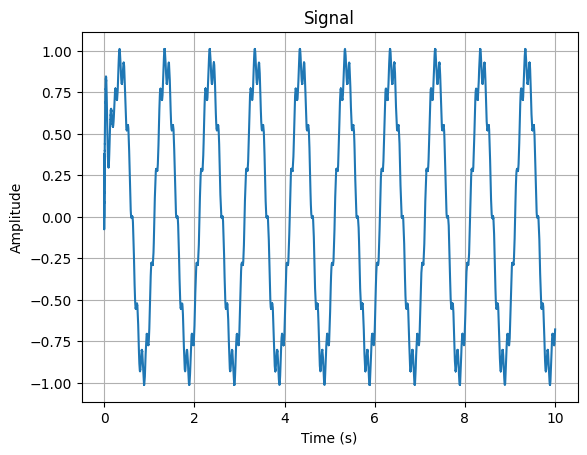

array([ 0.        ,  0.38034804, -0.07482157, ..., -0.67793258,
       -0.67780341, -0.67753386])

In [100]:
def movingAverageFilter(signal, L):
    y = np.zeros(len(signal))
    for sampleNumber in range(len(signal)):
        if(sampleNumber) < L:
            average = sum(signal[0 : sampleNumber + 1]) / (sampleNumber + 1)
        else:
            average = (sum(signal[sampleNumber - L : sampleNumber + 1])) / (L + 1)
        y[sampleNumber] = average
    
    return y

def fastMovingAverageFilter(signal, L):
    y = np.zeros(len(signal))
    previousTotal = 0
    for sampleNumber in range(len(signal)):
        if(sampleNumber) <= (L - 1):
            total = (previousTotal + signal[sampleNumber]) 
            previousTotal = total
            average = total / (sampleNumber + 1)
        else:
            total = previousTotal + signal[sampleNumber] - signal[sampleNumber - L]
            average = total / L
            previousTotal = total
        y[sampleNumber] = average
    
    return y


t = np.linspace(0, 10, fs*10)
signal = np.sin(2*np.pi*t) + np.sin(10 * 2*np.pi*t) + np.sin(16000 * 2*np.pi*t)

plot(t, signal)

filteredSignal = fastMovingAverageFilter(signal, 10000)
time = np.linspace(0, len(signal) / fs, len(signal))

plot(time, filteredSignal)

filteredSignal

Armar una única función de los snippets anteriores.

In [ ]:
# completar

Llamar a la función con algún impulso generado o descargado de la 2da entrega.

In [ ]:
# completar

Visualizar la señal con la función creada en la primer entrega.

In [ ]:
# completar

Reproducir señal resultante.

In [ ]:
# completar

Comentar sobre el resultado obtenido. ¿Qué está visualizando?  comparar con la señal original en el mismo gráfico.

*completar*

Se observan una gran diferencia. ¿Qué método de filtrado es más efectivo?

*completar*

## Función integral de Schroeder

También conocida como transformada de Schroeder. Permite aproximar el impulso a una señal más adecuada para calcular parámetros acústicos. 

**Consigna:** Realizar una función que aplique la siguiente expresión a las señales suavizadas:

\begin{equation}
E(t) = \int_{t}^{\infty}p^{2}(\tau) \partial\tau = \int_{0}^{\infty}p^{2}(\tau) \partial\tau - \int_{0}^{t}p^{2}(\tau) \partial\tau
\tag{17}
\end{equation}

Siendo $p(\tau)$ la respuesta al impulso y $t$ variando de $t\rightarrow\infty$ hasta el principio de $p(t)$. Con objetivo de minimizar la influencia del ruido de fondo en conveniente definir el extremo superior de la integral, en lugar de llevarla hasta el final del audio (usando Función Lundeby, opcional).

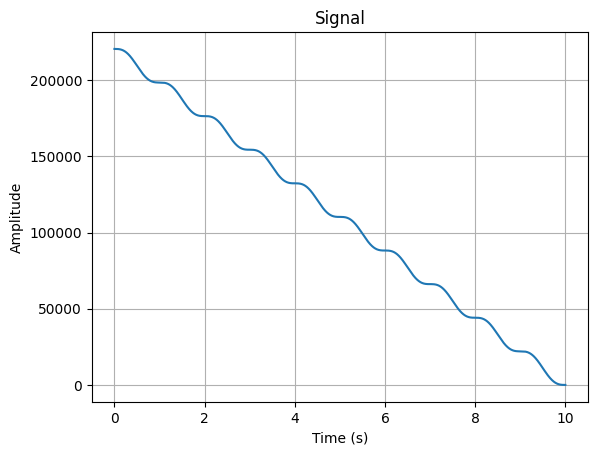

In [16]:
def schroederIntegral(signal):
    squaredSignal = signal ** 2
    totalEnergy = np.sum(squaredSignal)
    cumulativeEnergy = np.cumsum(squaredSignal)
    schroederIntegral = totalEnergy - cumulativeEnergy
    return schroederIntegral

t = np.linspace(0, 10, fs*10)
signal = np.sin(np.pi*t)

schroederIntegralSignal = schroederIntegral(signal)


plot(t, schroederIntegralSignal)


Llamar a la función con una señal suavizada.

In [ ]:
# completar

Visualizar la señal en escala logaritmica con la función creada en la 2da entrega, junto a la señal original antes de ser suavizada (tambien en escala logaritmica)

In [ ]:
# completar

Comentar lo que se observa en la visualización.

*completar*

## Función regresión lineal por mínimos cuadrados

La señal obtenida anteriormente es una nube de puntos concentrados con una clara tendencia, se desea optener una expresión matemática por medio de un método númerico para definir una recta que aproxime esta tendencia.

**Consigna**: Aplicar la aproximación por una recta obtenida de la regresión lineal por cuadrados mínimos de la respuesta al impulso suavizado y con algoritmo propio y no utilizando funciones predefinidas. Se puede utilizar funciones ya desarrolladas en otras librerias para comparar (por ejemplo, la libreria [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) ), con la función desarrollada. En el anexo C de ISO 3382 del año 2008, figura como implementar la regresión lineal en su modo clásico, en la asignatura se utiliza el método matricial. Elegir un método y aplicarlo. Calcular e indicar el error cuadratico medio entre los metodos utilizados

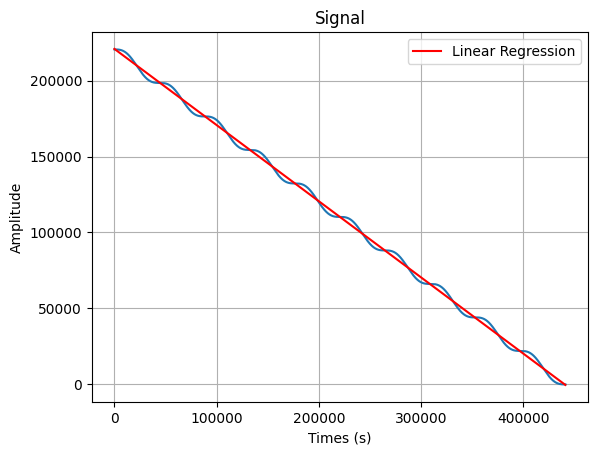

In [20]:
def linearRegression(y):
    n = len(y)
    x = list(range(1, n + 1))
    sumX = sum(x)
    sumY = sum(y)
    sumXy = sum(x_i * y_i for x_i, y_i in zip(x, y))
    sumXSquared = sum(x_i ** 2 for x_i in x)
    
    m = (n * sumXy - sumX * sumY) / (n * sumXSquared - sumX ** 2)
    b = (sumY - m * sumX) / n
    
    return m, b

# Regresión lineal
m, b = linearRegression(schroederIntegralSignal)
xFit = list(range(1, len(schroederIntegralSignal) + 1))
yFit = [m * xi + b for xi in xFit]

# Crear figura y plotear datos y regresión lineal
fig, ax = createFigure(range(1, len(schroederIntegralSignal) + 1), schroederIntegralSignal)
ax.plot(xFit, yFit, label="Linear Regression", color='red')
ax.legend()
plt.show()

Llamar a la función con una señal suavizada.

In [ ]:
# completar

Visualizar la recta obtenida respecto a la señal del punto anterior.

Comentar lo que se observa en la visualización.

*completar*

## Función cálculo de parámetros acústicos:  

**Consigna**: Desarrollar una función que permita calcular los siguientes parámetros acústicos definidos en la ISO 3382 (UNE-EN ISO 3382, 2010), a partir de la recta aproximada. Buscar en la normativa la definición de los siguiente parámetros:
1. EDT.
2. T60 a partir del T10, T20 y T30.
3. D50.
4. C80.

In [ ]:
# completar

Llamar a la función con la señal aproximada

In [ ]:
# completar

Comparar los resultados obtenidos con la señal sintetizada, con las señales descargadas y realizar una tabla comparativa. Ademas se puede hacer uso de herramientas como [REW(Room Acoustics Software)](https://www.roomeqwizard.com/) para comparar los resultados obtenidos

## Función Lundeby (opcional)

Investigar método(Y. Hirata,1982), para encontrar el extremo superior de integración de la ecuación 17. El método de Lundeby está basado en un algoritmo iterativo que selecciona el intervalo temporal más adecuado para el cual se calcula la regresión lineal, buscando eliminar contribuciones no deseadas. A continuación se describe el algoritmo.(Y. Hirata,1982):
1. Se calcula la media cuadrática (RMS) de la respuesta al impulso en intervalos de tiempo (10-50 ms).
2. Estimamos el nivel de ruido de fondo a partir de la cola reverberante (último 10% de la señal).
3. Estimamos la pendiente de decaimiento desde 0 db hasta el nivel del ruido (el punto “izquierdo” es el correspondiente a 0 dB. Buscamos el punto “derecho” 5 - 10 dB por sobre el nivel del ruido).
4. Encontrar el punto de cruce entre la regresión lineal y el nivel de ruido.
5. Encontrar nuevos intervalos locales basándose en la pendiente actual (usar entre  3-10 intervalos cada 10 dB de decaimiento).
6. Calcular la media cuadrática (RMS) de la respuesta al impulso en los nuevos intervalos locales.
7. Estimar ruido de fondo (comenzando por un punto de tiempo correspondiente a un decaimiento de 5-10 dB basándose en la pendiente actual luego del punto de cruce actual, tomando como longitud mínima el 10% de la RI).
8. Estimar la nueva pendiente de decaimiento (se debería evaluar un rango dinámico de 10-20 dB, comenzando en 5-10 dB sobre el nivel de ruido)
9. Encontrar un nuevo punto de cruce.
10. Repetir 7,8 y  9 hasta alcanzar un punto de convergencia.

## Informe final: 
Realizar un informe final, con el mismo formato establecido en el informe preliminar, pero en este caso no debe exceder las 5 páginas. Además se recuerda remitir solamente a detalles relevante, algunos puntos importantes son:
1. Contemplar las correcciones de la primera entrega.
2. En el informe debe figurar claramente cómo se unen todas las funciones definidas y la interacción entre ellas. Utilizar algun diagrama para visualizar dicha relación.
3. Mencionar detalladamente el procedimiento.
4. Mostrar curvas de filtros, plot del procesamiento de la seña.
5. Validación del algoritmo con software comercial.
6. Los informes finales entregados fuera de fecha no serán evaluados.

A modo ilustrastivo se muestra los porcentajes del contenido en los informes:

| Resumen | Introducción | Marco teórico | Desarrollo experimental | Resultados | Conclusiones |
| -- | -- | -- | -- | -- | --  |
| 5% | 10% | 10% | 25% | 30% | 20% |

### Extra

Para el diagrama de flujo recomendamos utilizar la siguiente herramienta [DrawIo](https://app.diagrams.net), a continuación se adjunta un ejemplo de lo que se espera:

![](../img/diagramFlow.png)

El archivo para generar dicho gráfico se encuentra en `trabajo_practico/diagramFlow.drawio`, se puede descargar y editar en la web del la app.